In [69]:
#|default_exp data

# Data

> Functions related to data processing in MOCATML

In [70]:
#|export
import numpy as np
from fastcore.all import *
import matplotlib.pyplot as plt
from tsai.data.preparation import SlidingWindow
from fastai.vision.all import *
from tsai.utils import np_load_compressed, toarray
import torch

In [71]:
#|export
# TODO: This should be an argument to create the data
# Discretization of the perigee argument
RP_DISC = [6578.137, 6628.137, 6678.137, 6728.137, 6778.137, 6828.137,
        6878.137, 6928.137, 6978.137, 7028.137, 7078.137, 7128.137,
        7178.137, 7228.137, 7278.137, 7328.137, 7378.137, 7428.137,
        7478.137, 7528.137, 7578.137, 7628.137, 7678.137, 7728.137,
        7778.137, 7828.137, 7878.137, 7928.137, 7978.137, 8028.137,
        8078.137, 8128.137, 8178.137, 8228.137, 8278.137, 8328.137,
        8378.137]
# Discretization of the area-to-mass ratio
AM_DISC = [1.00000000e-05, 1.14975700e-05, 1.32194115e-05, 1.51991108e-05,
        1.74752840e-05, 2.00923300e-05, 2.31012970e-05, 2.65608778e-05,
        3.05385551e-05, 3.51119173e-05, 4.03701726e-05, 4.64158883e-05,
        5.33669923e-05, 6.13590727e-05, 7.05480231e-05, 8.11130831e-05,
        9.32603347e-05, 1.07226722e-04, 1.23284674e-04, 1.41747416e-04,
        1.62975083e-04, 1.87381742e-04, 2.15443469e-04, 2.47707636e-04,
        2.84803587e-04, 3.27454916e-04, 3.76493581e-04, 4.32876128e-04,
        4.97702356e-04, 5.72236766e-04, 6.57933225e-04, 7.56463328e-04,
        8.69749003e-04, 1.00000000e-03, 1.14975700e-03, 1.32194115e-03,
        1.51991108e-03, 1.74752840e-03, 2.00923300e-03, 2.31012970e-03,
        2.65608778e-03, 3.05385551e-03, 3.51119173e-03, 4.03701726e-03,
        4.64158883e-03, 5.33669923e-03, 6.13590727e-03, 7.05480231e-03,
        8.11130831e-03, 9.32603347e-03, 1.07226722e-02, 1.23284674e-02,
        1.41747416e-02, 1.62975083e-02, 1.87381742e-02, 2.15443469e-02,
        2.47707636e-02, 2.84803587e-02, 3.27454916e-02, 3.76493581e-02,
        4.32876128e-02, 4.97702356e-02, 5.72236766e-02, 6.57933225e-02,
        7.56463328e-02, 8.69749003e-02, 1.00000000e-01, 1.14975700e-01,
        1.32194115e-01, 1.51991108e-01, 1.74752840e-01, 2.00923300e-01,
        2.31012970e-01, 2.65608778e-01, 3.05385551e-01, 3.51119173e-01,
        4.03701726e-01, 4.64158883e-01, 5.33669923e-01, 6.13590727e-01,
        7.05480231e-01, 8.11130831e-01, 9.32603347e-01, 1.07226722e+00,
        1.23284674e+00, 1.41747416e+00, 1.62975083e+00, 1.87381742e+00,
        2.15443469e+00, 2.47707636e+00, 2.84803587e+00, 3.27454916e+00,
        3.76493581e+00, 4.32876128e+00, 4.97702356e+00, 5.72236766e+00,
        6.57933225e+00, 7.56463328e+00, 8.69749003e+00, 1.00000000e+01]

In [72]:
#|export
@delegates(SlidingWindow)
def apply_sliding_window_3d(data, window_len, **kwargs):
    """
        Apply sliding window to 3D data. The data is assumed to have the shape
        (n_samples, n_features, n_time_steps).
        Input:
            data: 3D array
            window_len: int, length of the sliding window
            horizon: int, number of time steps to predict
            kwargs: additional arguments to SlidingWindow
        Output:
            X: 3D array, shape (n_samples, n_features, window_len)
            y: 3D array, shape (n_samples, n_features, horizon)
    """
    sw = SlidingWindow(window_len=window_len, **kwargs)
    # Apply the sliding window to every sample (loop on dimension 0) of the data
    slices = [sw(x) for x in data]
    # Concatenate the slices into single arrays (X and y)
    X = np.concatenate([s[0] for s in slices])
    y = np.concatenate([s[1] for s in slices])
    # In case y is a 2D array (config.horizon = 1), add the time dimension at the end
    if y.ndim == 2:
        y = np.expand_dims(y, -1)
    return X, y

In [73]:
# Test
data = np.random.rand(100, 3, 10)
X, y = apply_sliding_window_3d(data, window_len=4, horizon=1, seq_first=False, 
                               stride=None)
test_eq(X.shape, (200, 3, 4))
test_eq(y.shape, (200, 3, 1))

In [74]:
#|eval: false
#|hide
from nbdev import *
nbdev_export()

In [75]:
#|export
class DensityData:
    def __init__(self, data, lbk, h, gap=0):
        """
        Args:
            data: The data containing sequences of heatmaps. Shape should be 
            (n_samples, lookback+horizon+gap, height, width).
            lbk: Number of input frames to use as history (lookback).
            h: Number of output frames to forecast (horizon).
        """
        self.data = data
        self.lbk = lbk
        self.h = h
        # if gap is lower than 0, check that is no lower than -h
        if gap < 0:
            assert gap > -h, "negative gap must be greater than -h"
        else:
            # Check that the gap is not greater than the length of the sequence
            assert gap <= data.shape[1] - lbk - h, "gap is too large"
        self.gap = gap

    def __getitem__(self, idx):
        """
        Returns a single sample from the dataset, split into input and output sequences.
        """
        seq = self.data[idx]  # Shape: (lbk+gap+h, height, width)
        input = seq[:self.lbk]
        output = seq[self.lbk+self.gap:self.lbk+self.gap+self.h]
        
        input_tensor = torch.from_numpy(input).float().unsqueeze(1)  # Add channel dimension
        output_tensor = torch.from_numpy(output).float().unsqueeze(1)  # Add channel dimension

        return input_tensor, output_tensor
    
    def __len__(self):
        return len(self.data)

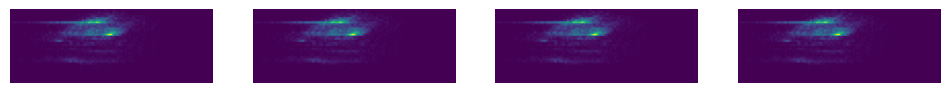

In [76]:
# Test
default_device(False)
# NOTE: This is only going to take the first 10 elements for each simulation
data = np_load_compressed('TLE_density_10_15x15.npy.gz', path='../example_data')
lbk = 3
h = 1
ds = DensityData(data, lbk=lbk, h=h)
x, y = ds[0]
test_eq(x.shape, (lbk, 1, 36, 99))
test_eq(y.shape, (h, 1, 36, 99))
z = torch.cat([x, y], dim=0)
show_images(z)


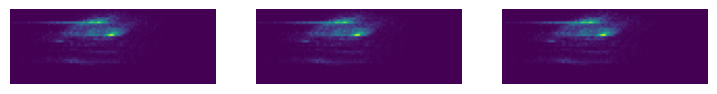

In [77]:
# with gap
lbk = 2
h = 1
gap = 1
ds2 = DensityData(data, lbk=lbk, h=h, gap=gap)
x, y = ds2[0]
test_eq(x.shape, (lbk, 1, 36, 99))
test_eq(y.shape, (h, 1, 36, 99))
z = torch.cat([x, y], dim=0)
show_images(z)


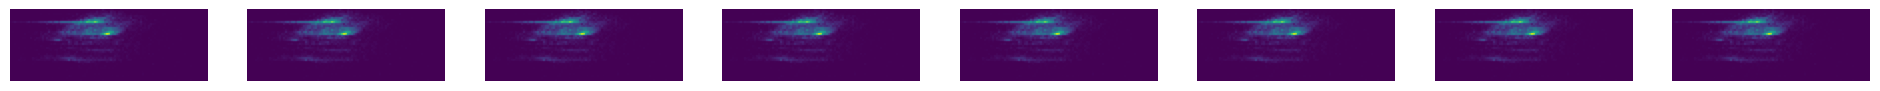

In [78]:
# try negative gaps
lbk = 4
h = 4
gap = -3
ds3 = DensityData(data, lbk=lbk, h=h, gap=gap)
x, y = ds3[0]
test_eq(x.shape, (lbk, 1, 36, 99))
test_eq(y.shape, (h, 1, 36, 99))
test_eq(x[1:], y[:-1])
z = torch.cat([x, y], dim=0)
show_images(z)


In [79]:
# If you want a fixed one
ds_fixed = [ds[i] for i in range(2)]

# As a Transform

> Refactor into fastai compatible transform

In [107]:
#|export
class DensitySeq(fastuple):
    @classmethod
    def create(cls, t):
        return cls(tuple(im for im in t))    
    
    @classmethod
    def from_preds_or_targs(cls, x, idx, dim=1, to_array=False):
        if to_array:
            return cls(toarray(torch.stack(x, dim=dim)[idx]))
        else:
            return cls(torch.stack(x, dim=dim)[idx])
        
    def to_preds_or_targs(self):
        if isinstance(self[0], torch.Tensor):
            # Handle tensors
            return tuple(torch.unsqueeze(t, 1) for t in self)
        else:
            # Handle numpy arrays
            return tuple(np.expand_dims(t, 1) for t in self)

    def show(self, start_epoch=0, x_disc=None, y_disc=None, title=None, 
             figsize=(4,3), epochs=None, **kwargs): 
        # If idxs is not provided, use all indices
        if epochs is None:
            epochs = range(len(self))

        # Number of plots is now the length of idxs
        n = len(epochs)
        fig, axes = plt.subplots(1, n, figsize=(n*figsize[0], figsize[1]))

        # Ensure axes is always an iterable (list of Axes)
        if n == 1: axes = [axes]

        for plot_idx, seq_idx in enumerate(epochs):
            t = self[seq_idx]
            ax = axes[plot_idx]

            # Display each tensor with specified extent
            if x_disc is not None and y_disc is not None:
                extent = [np.min(x_disc), np.max(x_disc), np.min(y_disc), np.max(y_disc)]
                im = ax.imshow(t.squeeze(), extent=extent, aspect='auto', **kwargs)
            else:
                im = ax.imshow(t.squeeze(), aspect='auto', **kwargs)

            # Set axis labels
            ax.set_xlabel('rp [km]' if x_disc is not None else '')
            ax.set_ylabel('Am [m^2/kg]' if plot_idx == 0 and y_disc is not None else '')

            # Set individual titles
            epoch_label = f'Epoch t{f"+{start_epoch + seq_idx}" if start_epoch + seq_idx > 0 else ""}'
            ax.set_title(epoch_label)

            # Enable the axis
            ax.axis('on')
        
        if title is not None: fig.suptitle(title)

        # Adjust layout to make room for x-axis labels if rotated
        plt.tight_layout()
        return axes


[<Axes: title={'center': 'Epoch t+3'}, xlabel='rp [km]', ylabel='Am [m^2/kg]'>]

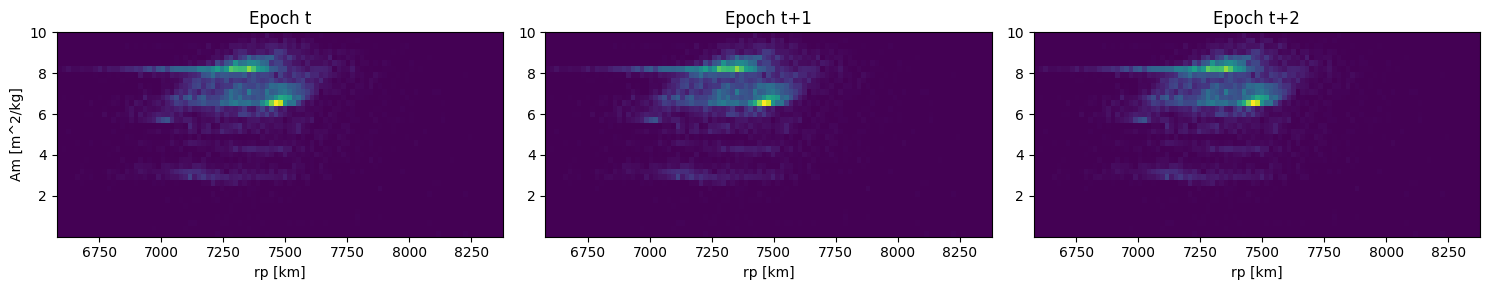

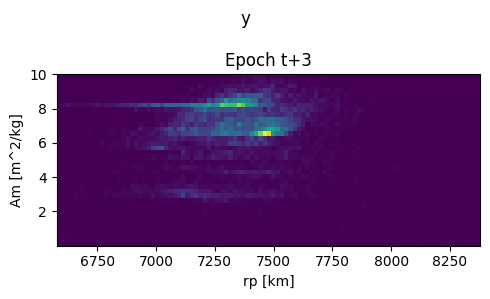

In [81]:
x,y = ds[0]
DensitySeq.create(x).show(figsize=(5,3), x_disc=RP_DISC, y_disc=AM_DISC)
DensitySeq.create(y).show(figsize=(5,3), start_epoch=3, x_disc=RP_DISC, 
                          y_disc=AM_DISC, title="y")

[<Axes: title={'center': 'Epoch t+2'}, xlabel='rp [km]', ylabel='Am [m^2/kg]'>]

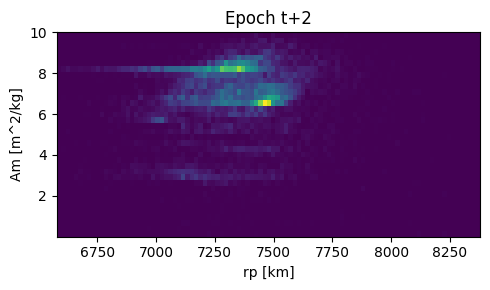

In [82]:
# Try only some indices
DensitySeq.create(x).show(figsize=(5,3), x_disc=RP_DISC, y_disc=AM_DISC, epochs=[2])

In [110]:
# Try creating from preds of 10 elements with horizon 4
h = 4
preds = tuple(torch.rand(10, 1, 36, 99) for _ in range(h))
p0 = DensitySeq.from_preds_or_targs(preds, idx=0)
test_eq(len(p0), h)
test_eq(p0[0].shape, (1, 36, 99))
p0_array = DensitySeq.from_preds_or_targs(preds, idx=0, to_array=True)
test_eq(toarray(p0), p0_array)


In [127]:
# Convert back to preds
p0_preds = p0.to_preds_or_targs()
test_eq(len(p0_preds), h)
test_eq(p0_preds[0].shape, (1, 1, 36, 99))
for i in range(h):
    test_eq(p0_preds[i][0], preds[i][0])
# With array too
p0_preds_array = p0_array.to_preds_or_targs()
test_eq(len(p0_preds_array), h)
test_eq(p0_preds_array[0].shape, (1, 1, 36, 99))
for i in range(h):
    test_eq(p0_preds_array[i][0], toarray(preds[i][0]))

In [84]:
#|export
class DensityTupleTransform(Transform):
    def __init__(self, ds):
        self.ds = ds
        
    def encodes(self, idx):
        x,y = self.ds[idx]
        return DensitySeq.create(x), DensitySeq.create(y)

In [85]:
train_tl = TfmdLists([0,1,2,3,4], DensityTupleTransform(ds))
valid_tl = TfmdLists([5,6,7,8,9], DensityTupleTransform(ds))

In [86]:
b = train_tl[0]
explode_types(b)

{tuple: [{__main__.DensitySeq: [torch.Tensor, torch.Tensor, torch.Tensor]},
  {__main__.DensitySeq: [torch.Tensor]}]}

In [87]:
dls = DataLoaders.from_dsets(train_tl, valid_tl, bs=5).to(default_device())

In [88]:
b = dls.one_batch()
explode_types(b)

{tuple: [{__main__.DensitySeq: [torch.Tensor, torch.Tensor, torch.Tensor]},
  {__main__.DensitySeq: [torch.Tensor]}]}

In [89]:
b[0][0].shape

torch.Size([5, 1, 36, 99])

In [90]:
#|export
# TODO: this is broken
@typedispatch
def show_batch(x:DensitySeq, y:DensitySeq, samples, ctxs=None, max_n=6, nrows=None, 
               ncols=2, figsize=None, **kwargs):
    if figsize is None: figsize = (ncols*6, max_n* 1.2)
    if ctxs is None: 
        _, ctxs = plt.subplots(min(x[0].shape[0], max_n), ncols, figsize=figsize)
    for i,ctx in enumerate(ctxs): 
        samples[i][0].show(ctx=ctx[0]), samples[i][1].show(ctx=ctx[1])

AttributeError: AxesImage.set() got an unexpected keyword argument 'ctx'

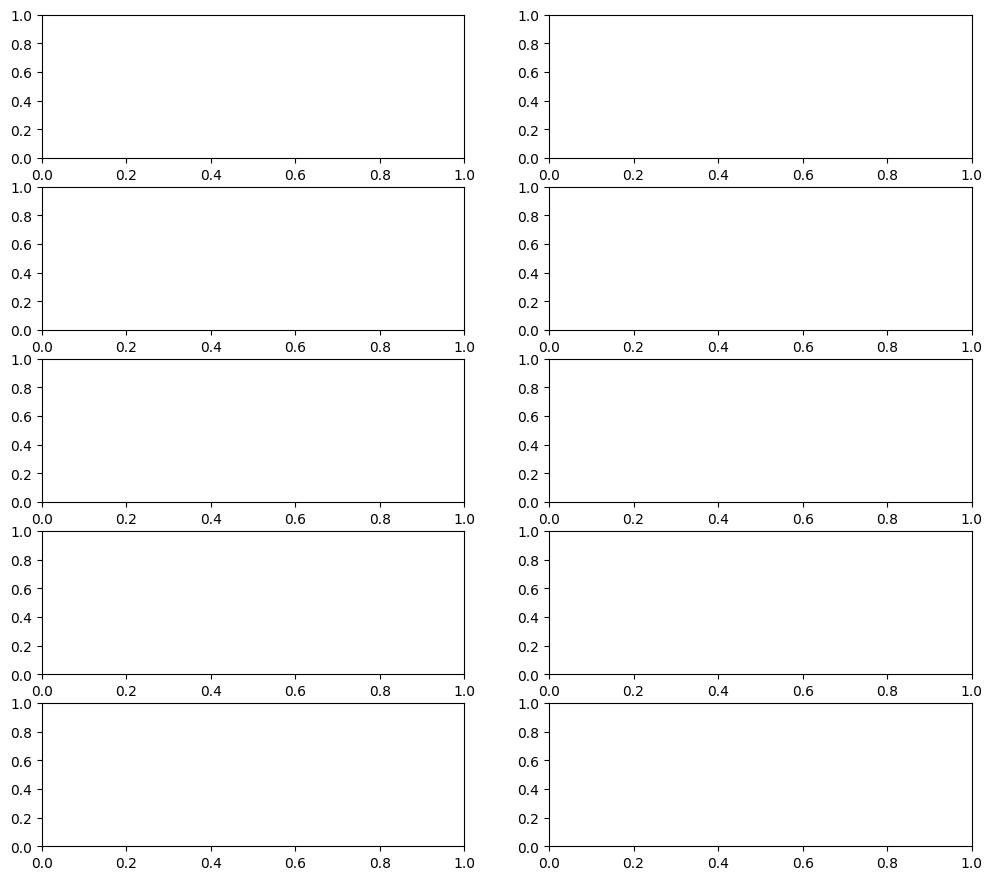

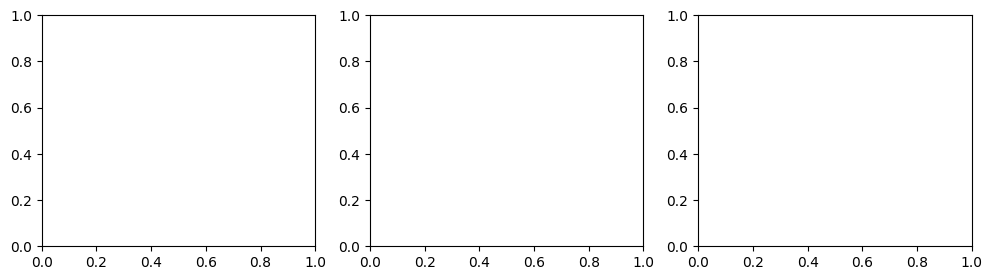

In [91]:
dls.show_batch()

In [92]:
#|export
def show_density_forecast(p, idx, figsize=(8,4), **kwargs):
    """
        Show predictions given as a list of tensors.
        Args:
            p:  list of tensors, each tensor is a prediction of shape 
                (n_samples, n_channels, height, width)
            idx: int, index of the sample to show
    """
    density_seq = DensitySeq.create([p[i][idx] for i in range(len(p))])
    density_seq.show(figsize=figsize, **kwargs)

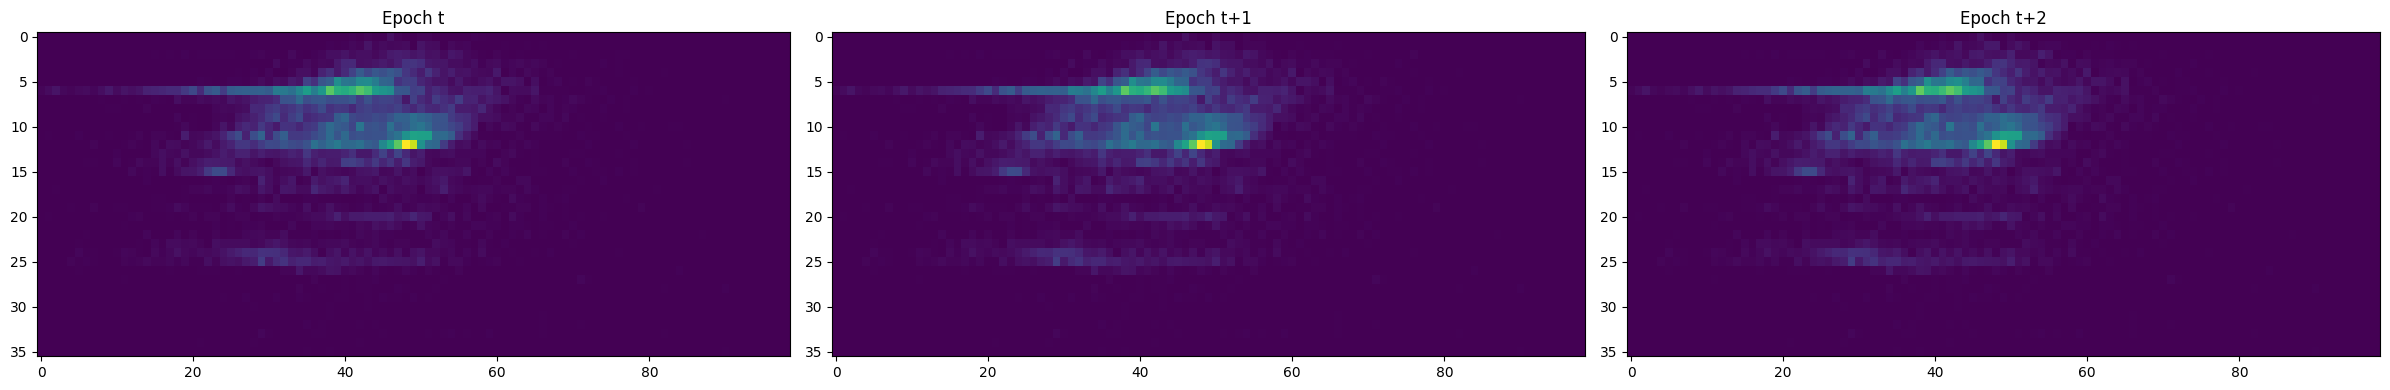

In [93]:
# test
show_density_forecast(b[0], 0)